In [1]:
%matplotlib inline


# IRFs and dataset cretion


**Objective: Create datasets well-suited to the IRFs properties**

## Introduction

We  will use the `~gammapy.data.DataStore` to retrieve a
list of selected observations (`~gammapy.data.Observations`).


Then, we need to
define the ON region containing the source and the geometry of the
`~gammapy.datasets.SpectrumDataset` object we want to produce. We then
create the corresponding dataset Maker.

We have to define the Maker object that will extract the OFF counts from
reflected regions in the field-of-view. To ensure we use data in an
energy range where the quality of the IRFs is good enough we also create
a safe range Maker.

We can then proceed with data reduction with a loop over all selected
observations to produce datasets in the relevant geometry.

We can then explore the resulting datasets and look at the cumulative
signal and significance of our source. We finally proceed with model
fitting.

In practice, we have to:

- Create a `~gammapy.data.DataStore` pointing to the relevant data
- Apply an observation selection to produce a list of observations,
  a `~gammapy.data.Observations` object.
- Define a geometry of the spectrum we want to produce:

  - Create a `~regions.CircleSkyRegion` for the ON extraction region
  - Create a `~gammapy.maps.MapAxis` for the energy binnings: one for the
    reconstructed (i.e.measured) energy, the other for the true energy
    (i.e.the one used by IRFs and models)

- Create the necessary makers :

  - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker` -
    the OFF background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
  - and the safe range maker : `~gammapy.makers.SafeMaskMaker`

- Perform the data reduction loop. And for every observation:

  - Apply the makers sequentially to produce a `~gammapy.datasets.SpectrumDatasetOnOff`
  - Append it to list of datasets


In [2]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

## Setup

As usual, we’ll start with some setup …




In [3]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    create_map_dataset_from_observation
)
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    DatasetsMaker,
    MapDatasetMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling.models import PiecewiseNormSpectralModel
from gammapy.maps import MapAxis, RegionGeom, WcsGeom


## Check setup



In [4]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_spectrum_datasets_off_regions

check_tutorials_setup()


System:

	python_executable      : /Users/qremy/anaconda3/envs/gpy-dev/bin/python 
	python_version         : 3.11.3     
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 1.3.dev459+g3cad7bf0a 
	path                   : /Users/qremy/Work/GitHub/gammapy/gammapy 


Other packages:

	numpy                  : 1.23.5     
	scipy                  : 1.12.0     
	astropy                : 5.2.2      
	regions                : 0.7        
	click                  : 8.0.4      
	yaml                   : 6.0        
	IPython                : 8.12.0     
	jupyterlab             : not installed 
	matplotlib             : 3.8.0      
	pandas                 : 2.0.2      
	healpy                 : 1.16.2     
	iminuit                : 2.21.3     
	sherpa                 : not installed 
	naima                  : 0.10.0     
	emcee                  : 3.1.4      
	corner                 : 2.2.2      
	ray                    : 2.9.0 

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula
(simulated events for now).

We will access the events, effective area, energy dispersion, livetime
and PSF for containment correction.




In [5]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

In [6]:
datastore.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47802,330.29538,-30.225555,17.818897,-52.742733,36.828686,53.171314,110.0,PKS 2155-304,329.71667,-30.225555,0.50002956,1688.0,1572.4065,0.9315204,241558291.0,241559979.0,2008-08-27,19:32:35.184,2008-08-27,20:00:43.184,4,"1,2,3,4",0,0.9731573,5998,PKS 2155-304 (steady),pks2155_steady,0.4998021,0.61659503,100.0


In [7]:
np.unique(datastore.obs_table["OBJECT"])

00:29:18 -73:00:00
00:35:50 -71:41:20
1ES 0145+138
1ES 0414+009
1ES 2343-151
3C 120
3C 273
47 Tuc NW
AE Aqr
...
PSR J0437-4715


**Exercise:**
- Use the `datastore.obs_table` to display only `"Crab Nebula"` observations using the `OBJECT` column
- get list of their `OBS_ID` and use it to get a list of observations using `datastore.get_observations` method

In [8]:
target_name = "Crab Nebula"
selection = datastore.obs_table["OBJECT"]==target_name
datastore.obs_table[selection]

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
23523,83.63333,21.514444,184.9823,-6.0516925,48.61021,41.38979,22.481705,Crab Nebula,83.63333,22.014444,0.5,1687.0,1581.7368,0.9376033,123890826.0,123892513.0,2004-12-04,22:08:10.184,2004-12-04,22:36:17.184,4,"1,2,3,4",0,0.9070748,7613,Crab,crab,0.500049,0.8709636,100.0
23526,83.63333,22.514444,184.13332,-5.5163794,45.77929,44.22071,8.542603,Crab Nebula,83.63333,22.014444,0.5,1683.0,1572.6868,0.9344544,123893580.0,123895263.0,2004-12-04,22:54:04.184,2004-12-04,23:22:07.184,4,"1,2,3,4",0,0.9142412,7581,Crab,crab,0.49995112,0.70794576,100.0
23559,85.253334,22.014444,185.35727,-4.510869,45.368176,44.631824,2.2535799,Crab Nebula,83.63333,22.014444,1.5018803,1686.0,1578.1235,0.9360163,124067051.0,124068737.0,2004-12-06,23:05:15.184,2004-12-06,23:33:21.184,4,"1,2,3,4",0,0.91964024,7601,Crab,crab,1.5021166,0.66069347,100.0
23592,82.013336,22.014444,183.7408,-7.047852,48.389248,41.610752,21.7556,Crab Nebula,83.63333,22.014444,1.5018733,1686.0,1581.2646,0.9378794,124235636.0,124237322.0,2004-12-08,21:55:00.184,2004-12-08,22:23:06.184,4,"1,2,3,4",0,0.9120389,7334,Crab,crab,1.5016365,0.8709636,100.0


In [9]:
obs_ids = datastore.obs_table[selection]["OBS_ID"]
observations = datastore.get_observations(obs_ids)

## How to choose the ON region size and the exclusion region sizes ?

Typically for point sources the ON region size is chosen to match the 68% containment radius of the PSF, while the exclusion region radius used to mask nearby sources is set to the 95% or 99% containment radius of the PSF. For extended sources one can consider the quadratic sum of the source radius and PSF radius.


In [10]:
obs0 = observations[0]
print(obs0.psf.info(
      fraction=[0.68, 0.95, 0.99, 0.68, 0.95, 0.99],
      energy_true=[1., 1., 1., 10, 10, 10]*u.TeV,
      offset=[0, 0, 0, 0, 0, 0]*u.deg)
     )


Summary PSF info
----------------
Theta          : size =     6, min =  0.000 deg, max =  2.500 deg
Energy hi      : size =    32, min =  0.013 TeV, max = 100.000 TeV
Energy lo      : size =    32, min =  0.010 TeV, max = 74.989 TeV
68.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.123 deg
95.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.301 deg
99.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.479 deg
68.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.108 deg
95.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.367 deg
99.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.555 deg



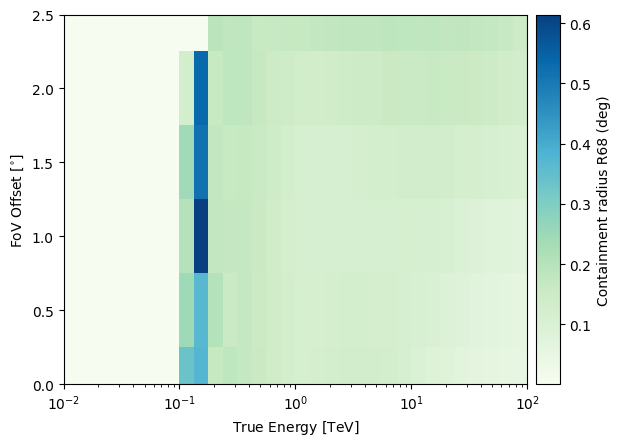

In [11]:
observations[0].psf.plot_containment_radius(fraction=0.68);


Here for simplicity we are are going to consider the median value in energy at offset zero for one observation. Ideally one should define for each observation an energy-dependent on-region at the offset matching the separation between the observation and target position.

In [12]:
on_region_radius = np.median(obs0.psf.containment_radius(fraction=0.68,
      energy_true=obs0.psf.axes["energy_true"].center,
      offset=0*u.deg))
print(on_region_radius)

0.1081318302080035 deg


and we do the same for the exclusion radius

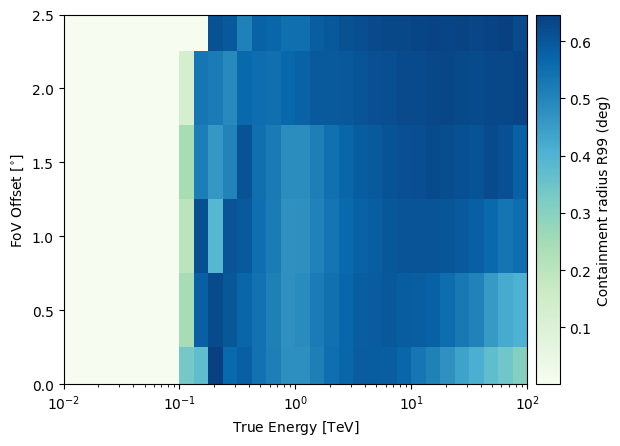

In [13]:
obs0.psf.plot_containment_radius(fraction=0.99);

In [14]:
exclusion_radius = np.median(obs0.psf.containment_radius(fraction=0.99,
      energy_true=obs0.psf.axes["energy_true"].center,
      offset=0*u.deg))
print(exclusion_radius)

0.4757364951074122 deg


## Define Target Region

The next step is to define a signal extraction region, also known as on
region. In the simplest case this is just a
[CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html)_.




In [15]:
target_position = SkyCoord.from_name("Crab Nebula").icrs
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## How to choose the dataset binning ?

A suitable binning for the dataset can be determined from the IRF,
For example the function  `gammapy.datassets.create_map_dataset_from_observation` use the following approach:
 * the number of bins per decade in energy is estimated from the energy resolution
      such as diff(ereco.edges)/ereco.center ~ min(eres)
 * the bin size estimated from the minimal 68% containment radius of the psf
 * the width estimated from the rad_max or the offset_max

Here we modified a bit the function available in gammapy such as :
 * the min/max reco energy is determined from the min/max events energy
 * a bug in _default_energy_axis is fixed

In [16]:
from scipy.stats import median_abs_deviation as mad
from gammapy.modeling.models import Models, FoVBackgroundModel
from gammapy.data import PointingMode
from gammapy.datasets import MapDataset

def _default_energy_axis(observation, energy_bin_per_decade_max=30):
    # number of bins per decade estimated from the energy resolution
    # such as diff(ereco.edges)/ereco.center ~ min(eres)
    etrue = observation.psf.axes[0]  # only where psf is defined
    eres = observation.edisp.to_edisp_kernel(0 * u.deg).get_resolution(etrue.center)
    eres = eres[np.isfinite(eres)]
    if eres.size > 0:
        # remove outliers
        beyond_mad = np.median(eres) - mad(eres) * eres.unit
        eres[eres < beyond_mad] = np.nan
        nbin_per_decade = np.nan_to_num(
            int(np.rint(2.0 / np.nanmin(eres.value))), nan=np.inf
        )
        nbin_per_decade = np.minimum(nbin_per_decade, energy_bin_per_decade_max)
    else:
        nbin_per_decade = energy_bin_per_decade_max

    energy_axis = MapAxis.from_energy_bounds(
        observation.events.energy.min(),
        observation.events.energy.max(),
        nbin=nbin_per_decade,
        per_decade=True,
        name="energy",
    )
    
    energy_axis_true = MapAxis.from_energy_bounds(
        etrue.edges[0],
        etrue.edges[-1],
        nbin=nbin_per_decade,
        per_decade=True,
        name="energy_true",
    )
        
    return energy_axis, energy_axis_true

def _default_binsz(observation, spatial_bin_size_min=0.01 * u.deg):
    # bin size estimated from the minimal r68 of the psf
    etrue = observation.psf.axes[0].edges  # only where psf is defined
    psf_r68 = observation.psf.containment_radius(
        0.68, energy_true=etrue, offset=0.0 * u.deg
    )
    psf_r68 = psf_r68[np.isfinite(psf_r68)]
    if psf_r68.size > 0:
        # remove outliers
        beyond_mad = np.median(psf_r68) - mad(psf_r68) * psf_r68.unit
        psf_r68[psf_r68 < beyond_mad] = np.nan
        binsz = np.nan_to_num(np.nanmin(psf_r68), nan=-np.inf)
        binsz = np.maximum(binsz, spatial_bin_size_min)
    else:
        binsz = spatial_bin_size_min
    return binsz

def _default_width(observation, spatial_width_max=12 * u.deg):
    # width estimated from the rad_max or the offset_max
    if observation.rad_max is not None:
        width = 2.0 * np.max(observation.rad_max)
    else:
        width = 2.0 * observation.psf.axes["offset"].edges[-1]
    return np.minimum(width, spatial_width_max)

def create_map_dataset_from_observation(
    observation,
    models=None,
    dataset_name=None,
    energy_axis_true=None,
    energy_axis=None,
    energy_bin_per_decade_max=30,
    spatial_width=None,
    spatial_width_max=12 * u.deg,
    spatial_bin_size=None,
    spatial_bin_size_min=0.01 * u.deg):
    """Create a MapDataset, if energy axes, spatial width or bin size are not given
    they are determined automatically from the observation IRFs,
    but the estimated value cannot exceed the given limits.

    Parameters
    ----------
    observation : `~gammapy.data.Observation`
        Observation to be simulated.
    models : `~gammapy.modeling.Models`, optional
        Models. Default is None.
    dataset_name : str, optional
        If `models` contains one or multiple `FoVBackgroundModel`
        it should match the `dataset_name` of the background model to use.
        Default is None. If None it is determined from the observation ID.
    energy_axis_true : `~gammapy.maps.MapAxis`, optional
        True energy axis. Default is None.
        If None it is determined from the observation IRFs.
    energy_axis : `~gammapy.maps.MapAxis`, optional
        Reconstructed energy axis. Default is None.
        If None it is determined from the observation IRFs.
    energy_bin_per_decade_max : int, optional
        Maximal number of bin per decade in energy for the reference dataset
    spatial_width : `~astropy.units.Quantity`, optional
        Spatial window size. Default is None.
         If None it is determined from the observation offset max or rad max.
    spatial_width_max : `~astropy.quantity.Quantity`, optional
        Maximal spatial width. Default is 12 degree.
    spatial_bin_size : `~astropy.units.Quantity`, optional
        Pixel size. Default is None.
        If None it is determined from the observation PSF R68.
    spatial_bin_size_min : `~astropy.quantity.Quantity`, optional
        Minimal spatial bin size. Default is 0.01 degree.

    """
    from gammapy.makers import MapDatasetMaker

    if spatial_width is None:
        spatial_width = _default_width(observation, spatial_width_max)
    if spatial_bin_size is None:
        spatial_bin_size = _default_binsz(observation, spatial_bin_size_min)
        
    if energy_axis is None:
        energy_axis,  energy_axis_true_ = _default_energy_axis(observation, energy_bin_per_decade_max)
    else:
        energy_axis_true_ = None

    if energy_axis_true is None:
        if energy_axis_true_ is None :
            energy_axis,  energy_axis_true_ = _default_energy_axis(observation, energy_bin_per_decade_max)
        energy_axis_true = energy_axis_true_

    if models is None:
        models = Models()

    if dataset_name is None:
        dataset_name = f"obs_{observation.obs_id}"

    if not np.any(
        [
            isinstance(m, FoVBackgroundModel) and m.datasets_names[0] == dataset_name
            for m in models
        ]
    ):
        models.append(FoVBackgroundModel(dataset_name=dataset_name))

    if observation.pointing.mode is not PointingMode.POINTING:
        raise NotImplementedError(
            "Only observations with fixed pointing in ICRS are supported"
        )
    pointing_icrs = observation.pointing.fixed_icrs
    geom = WcsGeom.create(
        skydir=pointing_icrs,
        width=spatial_width,
        binsz=spatial_bin_size.to_value(u.deg),
        frame="icrs",
        axes=[energy_axis],
    )

    components = ["exposure"]
    axes = dict(
        energy_axis_true=energy_axis_true,
    )
    if observation.edisp is not None:
        components.append("edisp")
        axes["migra_axis"] = observation.edisp.axes["migra"]
    if observation.bkg is not None:
        components.append("background")
    if observation.psf is not None:
        components.append("psf")

    dataset = MapDataset.create(
        geom,
        name=dataset_name,
        **axes,
    )

    maker = MapDatasetMaker(selection=components)
    dataset = maker.run(dataset, observation)
    dataset.models = models
    return dataset

In [17]:
empty_datasets = [create_map_dataset_from_observation(obs, spatial_width_max=2*exclusion_radius) for obs in observations]

/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [18]:
for d in empty_datasets[1:3]:
    print(d.counts.geom.wcs)
    print(d.counts.geom.axes[0])
    print(d.exposure.geom.axes[0])

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR'  'DEC--CAR'  
CRVAL : 83.633333333333  22.514444444444  
CRPIX : 9.0  9.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.05663738772273062  0.05663738772273062  
NAXIS : 17  17
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 23        
	node type  : edges     
	edges min  : 2.9e-01 TeV
	edges max  : 8.5e+01 TeV
	interp     : log       

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 37        
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR'  'DEC--CAR'  
CRVAL : 85.2533333381014  22.014444444444  
CRPIX : 9.0  9.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.055759679526090615  0.055759679526090615  
NAXIS : 17  17
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 22        
	node type  : edges     
	edges min  :

Note that here the binning is be different for each dataset so we can't stack them if needed. Let's create a common geometry that emcompass these and have a similar bining :

In [19]:
def get_reference_dataset(
    datasets,
    position,
    name,
    binsz=None,
    width=None,
    emin=None,
    emax=None,
    etrue_min=None,  
    etrue_max=None,
    nbin_per_decade=None):
    
    binsz_list=[]
    width_list=[]
    emin_list=[]
    emax_list=[]
    etrue_min_list=[]  
    etrue_max_list=[]
    nbin_per_decade_list=[]
    for d in datasets:
        binsz_list.append(np.abs(d.counts.geom.pixel_scales).min())
        width_list.append(d.counts.geom.width.max()+2*d.counts.geom.center_skydir.separation(target_position))
        emin_list.append(d.counts.geom.axes[0].edges.min())
        emax_list.append(d.counts.geom.axes[0].edges.max())
        etrue_min_list.append(d.exposure.geom.axes[0].edges.min())
        etrue_max_list.append(d.exposure.geom.axes[0].edges.max())
        ndecade = np.log10(etrue_max_list[-1].value)-np.log10(etrue_min_list[-1].value)
        nbins = len(d.exposure.geom.axes[0].center)
        nbin_per_decade_list.append( np.ceil(nbins/ndecade))

    if binsz is None:
        binsz = np.min(u.Quantity(binsz_list))
    if width is None:
        width = np.max(u.Quantity(width_list))
    if etrue_min is None:
        etrue_min = np.min(u.Quantity(etrue_min_list))
    if etrue_max is None:
        etrue_max = np.max(u.Quantity(etrue_max_list))
    if emin is None:
        emin = np.min(u.Quantity(emin_list))
    if emax is None:
        emax = np.max(u.Quantity(emax_list))
    emin = np.maximum(emin, etrue_min)
    emax = np.minimum(emax, etrue_max)
    if nbin_per_decade is None:
        nbin_per_decade = np.max(nbin_per_decade_list)
    energy_axis = MapAxis.from_energy_bounds(emin, emax, nbin_per_decade, unit="TeV", per_decade=True)

    geom = WcsGeom.create(
        skydir=target_position,
        binsz=binsz,
        width=(width, width),
        frame="galactic",
        proj="CAR",
        axes=[energy_axis],
    )

    # Reduced IRFs are defined in true energy (i.e. not measured energy).
    energy_axis_true = MapAxis.from_energy_bounds(
        etrue_min, etrue_max, nbin_per_decade, unit="TeV", name="energy_true", per_decade=True
    )
    return MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name=name)


In [20]:
reference_dataset = get_reference_dataset(empty_datasets, position=target_position, name="HESS_"+target_name)

In [21]:
print(reference_dataset.counts.geom.wcs)
print(reference_dataset.counts.geom.axes[0])
print(reference_dataset.exposure.geom.axes[0])

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : 184.5551014904497  -5.787682034518359  
CRPIX : 36.0  36.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.055759679526090615  0.055759679526090615  
NAXIS : 71  71
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 27        
	node type  : edges     
	edges min  : 2.4e-01 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 41        
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



In [22]:
empty_dataset_1d = reference_dataset.to_spectrum_dataset(on_region, name=d.name)


## Create exclusion mask

We will use the reflected regions method to place off regions to
estimate the background level in the on region. To make sure the off
regions don’t contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there’s only one known
gamma-ray source near the Crab nebula: the AGN called [RGB
J0521+212](http://gamma-sky.net/#/cat/tev/23)_ at GLON = 183.604 deg
and GLAT = -8.708 deg.




In [23]:
excluded_source =  "RGB J0521+212"
excluded_position = SkyCoord.from_name("RGB J0521+212").galactic
print(excluded_position)

<SkyCoord (Galactic): (l, b) in deg
    (183.60416634, -8.70833339)>


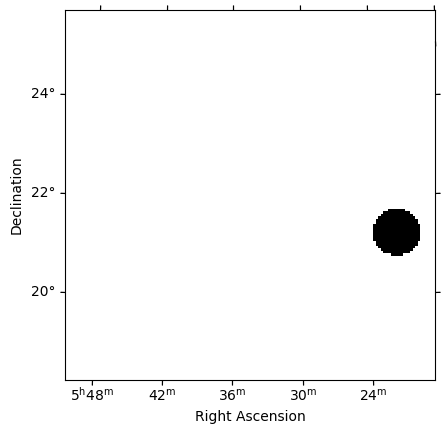

In [24]:
exclusion_region = CircleSkyRegion(
    center=excluded_position,
    radius=exclusion_radius,
)

skydir = target_position.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

## Data reduction 1D


We begin with the configuration of the maker classes:


In [25]:

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
makers = [dataset_maker, safe_mask_masker, bkg_maker] # the order is important


then we perform data data reduction loop


In [26]:
%time
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(empty_dataset_1d.copy(name=f"_hess_obs{obs_id}"), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)

print(datasets)


CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 5.96 µs
Datasets
--------




## Save the Datasets



In [27]:
path = Path("../datasets/crab_1d")
path.mkdir(exist_ok=True)

datasets.write(filename= path / "datasets_crab_1d.yaml", overwrite=True)

## Data reduction 3D
The workflow but we have to use different makers:



In [28]:
dataset_maker = MapDatasetMaker()
safe_mask_maker = SafeMaskMaker(methods=["aeff-max", "offset-max"], aeff_percent=10, offset_max=2*u.deg)
bkg_maker = FoVBackgroundMaker(method="fit")
makers = [dataset_maker, safe_mask_maker, bkg_maker] # the order is important


Here instread of a loop we perform the data reduction chain using the `DatasetsMaker`

In [29]:
%time
makers = [dataset_maker, safe_mask_maker, bkg_maker] # the order is important

datasets_maker = DatasetsMaker(makers=makers,
                         stack_datasets=True, #this time we stack to save memory usage
                         n_jobs=4)

datasets = datasets_maker.run(
                            dataset=reference_dataset,
                            observations=observations,
                        )
print(datasets)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : HESS_Crab Nebula
  Instrument : 
  Models     : 




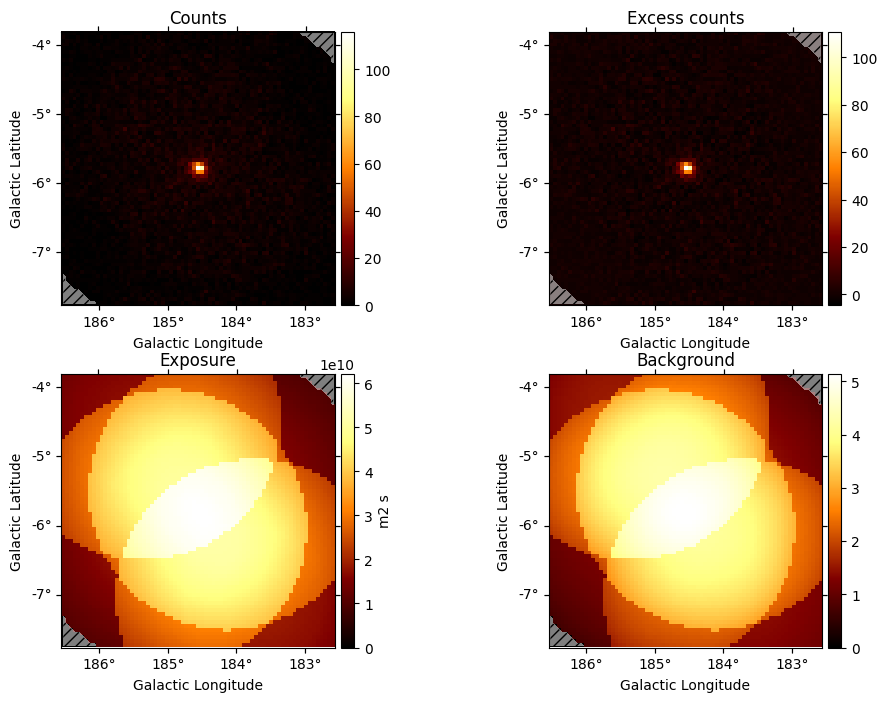

In [30]:
datasets[0].peek()

By default only the normalisation of background model of each observation is reffited. In order to correct for the spectral shape of the background model one can refit a normalisation in each energy bin. This is particularly important below the background peak where the curvature of the model is not always good.


The fit cannot be performed in each energy bin because there is not enough statistic at high energy 

In [31]:
datasets[0].counts.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

here we compute the sparcity that gives the fraction of empty bins

In [32]:
def sparsity(image):
    return 1.0 - (np.count_nonzero(image) / float(image.size))
counts_sparsity = np.array([sparsity(counts.data) for counts in datasets[0].counts.iter_by_image()])

Text(0, 0.5, 'Sparcity')

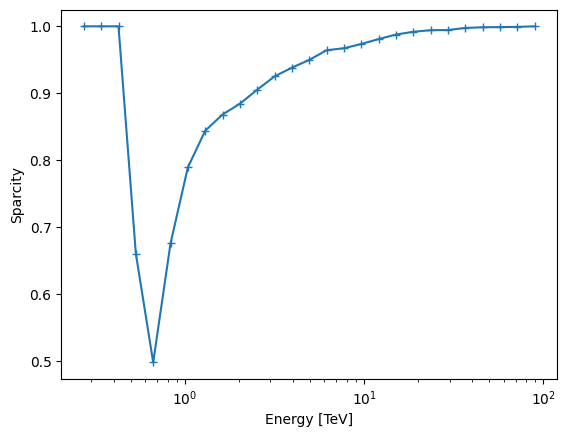

In [33]:
energy = datasets[0].counts.geom.axes[0].center
plt.semilogx(energy, counts_sparsity, "+-")
plt.xlabel("Energy [TeV]")
plt.ylabel("Sparcity")

so we choose only bins below a give threshold in sparcity 

In [34]:
ernergy_bins = energy[counts_sparsity<0.99]
#ernergy_bins = np.append(energy[counts_sparsity<0.99], energy[-1])#[::2]

In [35]:
ernergy_bins

<Quantity [ 0.5323442 ,  0.66519701,  0.83120482,  1.03864185,  1.29784726,
            1.62174045,  2.02646503,  2.53219344,  3.16413237,  3.95377917,
            4.94049169,  6.17345005,  7.7141078 ,  9.63925497, 12.04484549,
           15.05077967] TeV>

In [36]:
spectral_model = PiecewiseNormSpectralModel(ernergy_bins)

In [37]:
bkg_maker = FoVBackgroundMaker(method="fit", spectral_model=spectral_model)
offset_mask_maker = SafeMaskMaker(methods=["offset-max"], offset_max=2*u.deg)
# here we apply the offset_mask_maker only after the bkg_maker
# so we a larger region and then more stat in each energy bin to fit the background per energy bin 

makers = [dataset_maker, safe_mask_maker, bkg_maker, offset_mask_maker] # the order is important
datasets_maker = DatasetsMaker(makers=makers,
                         stack_datasets=False, #we don't stack to inspect the fitted bkg for each dataset
                         n_jobs=4)#the fit has more parameter now so take more time then we run it in parallel

datasets = datasets_maker.run(
                            dataset=reference_dataset,
                            observations=observations,
                        )

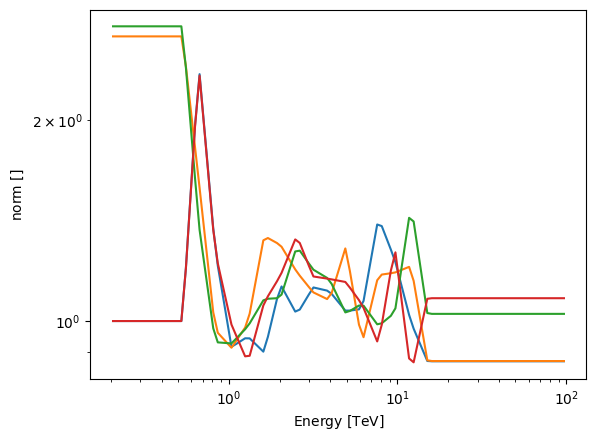

In [38]:
for d in datasets:
    d.background_model.spectral_model.plot([0.2,100]*u.TeV)

**Now you can check the modeling and fitting tutorial to read this dataset and analyse the data**